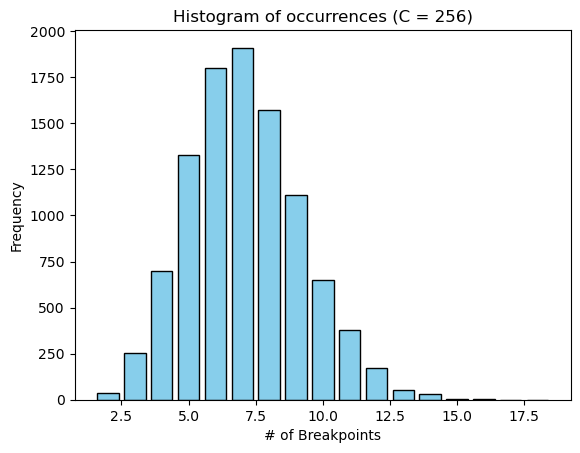

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

def knapsack_specialized(xi, v, w, C):
    """
    Solves a specialized knapsack problem using a specialized method in a vectorized way

    Args:
        xi (torch.Tensor): xi variables.
        v (torch.Tensor): Quantization vector.
        w (torch.Tensor): Weight vector.
        C (int): Number of buckets of quantization.

    Returns:
        tuple: Optimal allocation (x_opt), optimal multipliers (lambda_opt), and objective values.
    """
    
    b_list = []
    b = 0
    iterations = 0
    # Compute breakpoint vector x_plus
    while True:
        iterations += 1
        delta_xi = (xi[b + 1:] - xi[b])
        delta_v = (v[b + 1:] - v[b])
        b = torch.argmin(delta_xi / delta_v) + 1 + b_list[-1] if b_list else 0

        if b != C - 1:
            b_list.append(int(b))

        if b + 1 > C - 1:
            break
    b_list.append(C - 1)
    x_plus = torch.zeros(C, dtype=torch.int32)
    b_tensor = torch.tensor(b_list, dtype=torch.int32)
    x_plus[b_tensor] = 1

    # Determine optimal allocation based on w
    w_idx = torch.searchsorted(v, w) 
    indices_breakpoints = torch.nonzero(x_plus == 1).squeeze()

    # Creation of masks for extreme cases
    mask_right = w > v[-1]
    mask_left = w < v[0]

    # Find indices using searchsorted
    search_idx = torch.searchsorted(indices_breakpoints, w_idx)

    # Ensure that the indices are valid
    search_idx = torch.clamp(search_idx, 1, len(indices_breakpoints) - 1)

    # Initialize idx_right and idx_left with the result of the search
    idx_right = indices_breakpoints[search_idx]
    idx_left = indices_breakpoints[search_idx - 1]

    # Correct the indices for extreme cases
    idx_right = torch.where(mask_right, indices_breakpoints[-1], idx_right)
    idx_left = torch.where(mask_right, indices_breakpoints[-1], idx_left)

    # Correct the indices for the case when w < v[0]
    idx_right = torch.where(mask_left, indices_breakpoints[0], idx_right)
    idx_left = torch.where(mask_left, indices_breakpoints[0], idx_left)

    # Compute convex combination for optimal solution
    x1, x2 = torch.zeros(2, len(w), C, dtype=torch.float32)

    x1[torch.arange(len(w)), idx_left] = 1
    x2[torch.arange(len(w)), idx_right] = 1

    numerator = w - torch.matmul(x2, v)
    denominator = torch.matmul((x1 - x2), v)
    theta = numerator / denominator

    mask_equal = (x1 == x2)
    theta_expanded = theta.unsqueeze(1)
    x_opt = torch.where(mask_equal, x1, x1 * theta_expanded + x2 * (1 - theta_expanded))

    # Compute optimal multipliers
    denominator = (v[idx_right] - v[idx_left])
    denominator_zero_mask = denominator == 0

    lambda_opt_nonzero = (xi[idx_right] - xi[idx_left]) / denominator
    lambda_opt_zero_full = xi / v
    lambda_opt_zero_full[0] = 0
    lambda_opt_zero = lambda_opt_zero_full[idx_left]

    lambda_opt = torch.where(denominator_zero_mask, lambda_opt_zero, lambda_opt_nonzero)

    # Compute objective function values
    objective_values = torch.matmul(x_opt, xi)

    return x_opt, lambda_opt, objective_values, iterations
        
# Select device based on availability of CUDA
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

C = 256
M = 1

iterations = []

# Run the algorithm 10,000 times
for i in range(10000):
    xi = torch.sort(torch.rand(C, device=device))[0]  
    v = torch.linspace(0, 1 - (1 / C), C, device=device)  
    #w = v[torch.randint(0, C, (1,), device=device)]  
    w = torch.rand(M, device=device)

    x_opt, lambda_opt, optimal_value, iterations_count = knapsack_specialized(xi, v, w, C)

    iterations.append(iterations_count)

# Count occurrences of elements in the list
occurrences = Counter(iterations)

# Extract keys and values for histogram
elements = list(occurrences.keys())
frequencies = list(occurrences.values())

# Create histogram
plt.bar(elements, frequencies, color="skyblue", edgecolor="black")
plt.xlabel("# of Breakpoints")
plt.ylabel("Frequency")
plt.title("Histogram of occurrences (C = 256)")
plt.show()


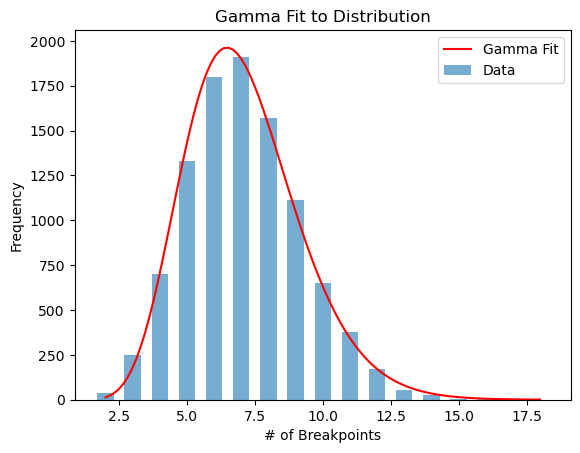

In [2]:
from scipy.stats import gamma

# Parameter estimation for the Gamma distribution
mean_val = np.average(elements, weights=frequencies)
var_val = np.average((elements - mean_val)**2, weights=frequencies)
shape_est = (mean_val ** 2) / var_val
scale_est = var_val / mean_val

# Creation of theoretical values for the Gamma distribution
x_values = np.linspace(min(elements), max(elements), 100)
gamma_fit = gamma.pdf(x_values, a=shape_est, scale=scale_est) * sum(frequencies)

# Plot the histogram
plt.bar(elements, frequencies, width=0.6, alpha=0.6, label="Data")
plt.plot(x_values, gamma_fit, '-', markersize=7, label="Gamma Fit", color="red")

# Labels and legend
plt.xlabel('# of Breakpoints')
plt.ylabel('Frequency')
plt.legend()
plt.title("Gamma Fit to Distribution")
plt.show()


In [3]:
# Compute the probability for a specific x value using log and advanced precision
x_specific = 256  # Replace with the desired value
log_probability = gamma.logpdf(x_specific, a=shape_est, scale=scale_est)
probability = np.exp(log_probability)
print(f"The probability for x={x_specific} is {probability:.6e}")

The probability for x=256 is 1.819911e-157
